# Datasets in MagnetoPy: The `Magnetometry` Class

The [`Magnetometry`](../../api/magnetometry/#magnetopy.magnetometry.Magnetometry) class contains magnetometry data for a single sample along with methods for parsing, processing, and analyzing the data. Note that "single sample" means that in situations in which a single material is measured in multiple samples, each sample should be treated as a separate `Magnetometry` object.

In [1]:
import json
from pathlib import Path

import magnetopy as mp

DATA_PATH = Path("../../tests/data")

## Creating a `Magnetometry` Object

To create a `Magnetometry` object, simply pass the path of the folder which contains all of the data files for the sample.

In [2]:
dset1 = mp.Magnetometry(DATA_PATH / "dataset1")

The default behavior sets the `sample_id` attribute to the name of the folder.

In [3]:
dset1.sample_id

'dataset1'

A different `sample_id` can be passed during object construction:

In [4]:
dset1 = mp.Magnetometry(DATA_PATH / "dataset1", sample_id="new_sample_id")
dset1.sample_id

'new_sample_id'

Since they can take a long time to process, raw data files (.rw.dat) files are ignored by default. If you need access to the raw data, pass `parse_raw=True` to the constructor. 

In [5]:
dset2 = mp.Magnetometry(DATA_PATH / "dataset2")
try:
    dset2.mvsh[0].plot_raw()
except mp.data_files.NoRawDataError as e:
    print(e)

This DatFile object does not contain raw data.


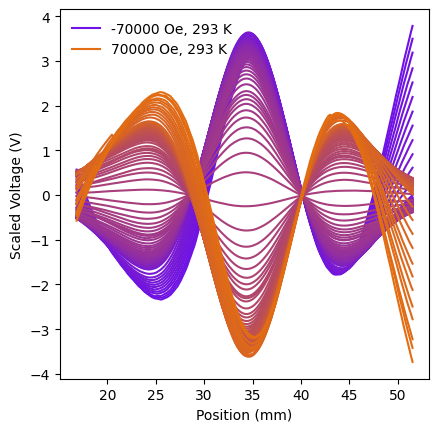

In [6]:
dset2 = mp.Magnetometry(DATA_PATH / "dataset2", parse_raw=True)
fig, ax = dset2.mvsh[0].plot_raw()

## Files and Experiments

For now we'll focus on the attributes `files`, `mvsh`, `zfc`, and `fc`. `files` contains a list of the data files comprising the dataset. The latter three contain lists of the `MvsH`, `ZFC`, and `FC` objects, respectively, which were found within the dataset's files.

For example, the following dataset, `dset1`, has several `MvsH` experiments found within one file, and a single "zfcfc" file which is separated into `ZFC` and `FC` experiments:

In [7]:
dset1 = mp.Magnetometry(DATA_PATH / "dataset1")
dset1.files

[DatFile(mvsh1.dat), DatFile(zfcfc1.dat)]

In [8]:
dset1.mvsh

[MvsH at 2 K,
 MvsH at 4 K,
 MvsH at 6 K,
 MvsH at 8 K,
 MvsH at 10 K,
 MvsH at 12 K,
 MvsH at 300 K]

Inspecting one of the `MvsH` objects shows which file it came from.

In [9]:
dset1.mvsh[0].as_dict()

{'origin_file': 'mvsh1.dat',
 'temperature': 2,
 'field_range': (-70000.35156, 70000.375),
 'field_correction_file': '',
 'scaling': ['molar', 'eicosane']}

The `zfc` and `fc` attributes are single-item lists, and we can see that the `ZFC` and `FC` objects are from the same file.

In [10]:
dset1.zfc[0].origin_file, dset1.fc[0].origin_file

('zfcfc1.dat', 'zfcfc1.dat')

## Experiment Getter Methods

The `get_mvsh()`, `get_zfc()`, and `get_fc()` are convenience methods for accessing specific experiment objects based on nominal values of temperature or field. For example, `dset1` contains several `MvsH` experiments at various temperatures, and we can access the one at 2 K using the `get_mvsh()` method:

In [11]:
mvsh_2k = dset1.get_mvsh(2)
mvsh_2k.as_dict()

{'origin_file': 'mvsh1.dat',
 'temperature': 2,
 'field_range': (-70000.35156, 70000.375),
 'field_correction_file': '',
 'scaling': ['molar', 'eicosane']}

## Sample Info and Scaling Data

The `sample_info` attribute of `Magnetometry` objects contains information about the sample stored as a [`SampleInfo`](../../api/magnetometry/#magnetopy.magnetometry.SampleInfo) object. It's assumed that all files within the dataset are for the same sample, so the `sample_info` data is extracted from the header of the first file in the dataset.

In [12]:
dset1 = mp.Magnetometry(DATA_PATH / "dataset1")
dset1.sample_info.as_dict()

{'material': '[Er(TiPS2COT)I(THF)]2',
 'comment': 'salmon powder in eicosane',
 'mass': 19.8,
 'volume': None,
 'molecular_weight': 1566.22,
 'size': None,
 'shape': None,
 'holder': 'Straw',
 'holder_detail': 'Standard',
 'offset': 66.27,
 'eicosane_mass': 32.4,
 'diamagnetic_correction': 0.0}

The data of the `MvsH`, `ZFC`, and `FC` objects within the dataset are automatically scaled during `Magnetometry` object creation based on 1) what information is found and placed in the `sample_info` attribute, and 2) value of the `magnetic_data_scaling` argument passed to the constructor. The default for this argument is `"auto"` which means that the data will be scaled based on the information found in the `sample_info` attribute. Other possible values are explained in the [underlying utility function](../../api/experiments_utils/#magnetopy.experiments.utils.scale_dc_data).

In [13]:
dset1.magnetic_data_scaling

['auto']

The individual experiment objects have a `scaling` attribute to record what scaling operations were done to it.

In [14]:
dset1.mvsh[0].scaling

['molar', 'eicosane']

We can force a dataset to have a particular scaling by passing the `magnetic_data_scaling` argument to the constructor.

In [15]:
dset1 = mp.Magnetometry(
    DATA_PATH / "dataset1",
    magnetic_data_scaling="mass"
)
dset1.mvsh[0].scaling

['mass']

Or we can change the scaling after `Magnetometry` object creation. For example, let's say the sample under investigation is a silica-shelled magnetite nanoparticle, and the `sample_info.mass` value represents the mass of the silica-shelled particles. We may want to use other experimental info, like TGA, to scale the data to the mass of the magnetite core. We can do this by changing the `sample_info.mass` value and then calling the `scale_data` method.

In [16]:
dset3 = mp.Magnetometry(DATA_PATH / "dataset3")
dset3.mvsh[0].simplified_data()['moment'].max()

51.68514382735617

In [17]:
dset3.mvsh[0].scaling

['mass']

So the as-read saturation magnetization from that M vs. H experiment is 70.8 emu/g. Now we can scale the data to the mass of the magnetite core.

In [18]:
dset3.sample_info.mass = dset3.sample_info.mass * 0.75
dset3.scale_dc_data()
dset3.mvsh[0].simplified_data()['moment'].max()

68.91352510314155

## Correcting the Field in `MvsH` Objects for Flux Trapping

As discussed on the [`MvsH` example page](../../examples/mvsh/#correcting-the-field-for-flux-trapping), the field in `MvsH` objects can be corrected for flux trapping by calling the [`MvsH.correct_field()`](../../api/mvsh/#magnetopy.experiments.mvsh.MvsH.correct_field) method with the path to a file containing the Pd field calibration data. The `Magnetometry` class provides a convenience method for this, as it is likely that all `MvsH` objects within a dataset will be collected with the same sequence of field values.

The field correction can be applied during object creation by passing the `true_field_correction` argument to the constructor -- as with `MvsH.correct_field()`, this argument can be the path of the standard file or, as shown below, the name of the sequence defined in the user's [Standard Calibration Library](../../standard_calibration_library).

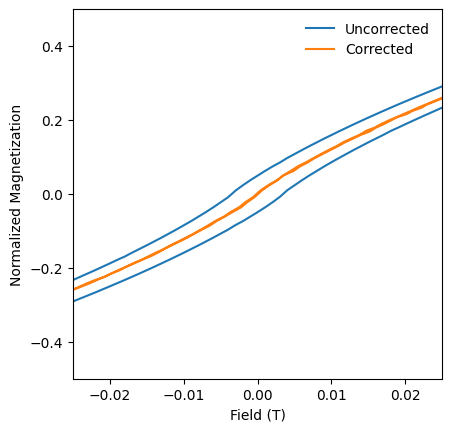

In [19]:
dset3_uncorrected = mp.Magnetometry(DATA_PATH / "dataset3")
dset3_corrected = mp.Magnetometry(
    DATA_PATH / "dataset3",
    true_field_correction="sequence_1"
)

fig, ax = mp.plot_mvsh(
    [
        dset3_uncorrected.mvsh[0],
        dset3_corrected.mvsh[0],
    ],
    normalized=True,
    labels=[
        "Uncorrected",
        "Corrected",
    ],
    xlim = (-0.025, 0.025),
    ylim = (-0.5, 0.5),
)


## Plotting

The `Magnetometry` class has some convenience methods for plotting all of the `MvsH` and `ZFC`/`FC` pairs within the dataset. 

### M vs. H

[`Magnetometry.plot_mvsh()`](../../api/magnetometry/#magnetopy.magnetometry.Magnetometry.plot_mvsh) works much the same as was described in the [`MvsH` tutorial](examples/mvsh/#plotting), but has an additional argument `temperatures` which filters the experiments to be plotted based on their nominal temperature.

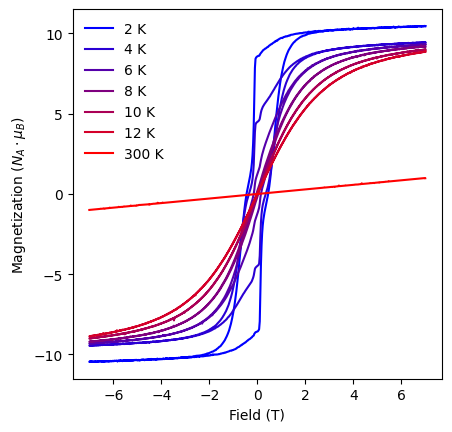

In [20]:
dset1 = mp.Magnetometry(DATA_PATH / "dataset1")
fig, ax = dset1.plot_mvsh()

Now removing the 300 K experiment from the plot:

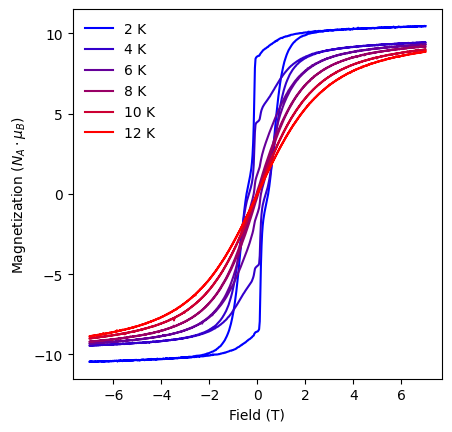

In [21]:
fig, ax = dset1.plot_mvsh([2, 4, 6, 8, 10, 12])

### ZFC/FC

[`Magnetometry.plot_zfcfc()`](../../api/magnetometry/#magnetopy.magnetometry.Magnetometry.plot_zfcfc) plots all of the pairs of `ZFC` and `FC` experiments within the dataset.

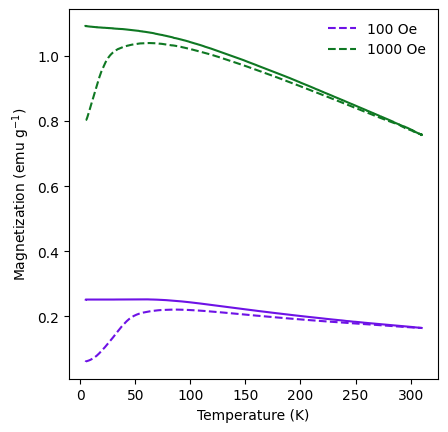

In [22]:
dset3 = mp.Magnetometry(DATA_PATH / "dataset3")
fig, ax = dset3.plot_zfcfc()

The `fields` argument can be used to filter the experiments to be plotted based on their nominal field.

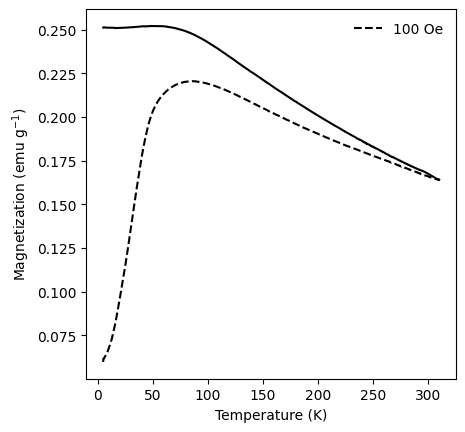

In [23]:
fig, ax = dset3.plot_zfcfc(fields=[100])

The `y_val` argument changes the units of the y-axis. The default is `"moment"`; `"chi"` and `"chi_t"` are also available.

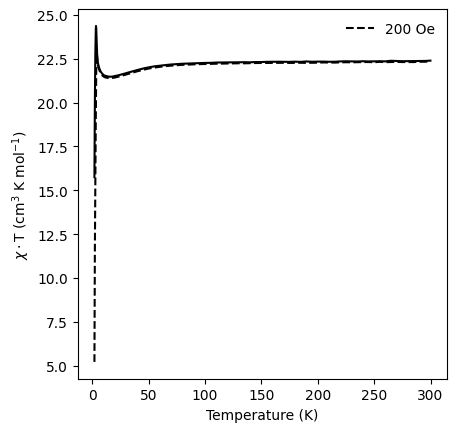

In [24]:
dset4 = mp.Magnetometry(DATA_PATH / "dataset4")
fig, ax = dset4.plot_zfcfc(y_val="chi_t")

## Analyses and Serialization

Perhaps the most important aspect of MagnetoPy is the modular nature in which analyses can be developed and the way in which the results of those analyses can be serialized and shared. When publishing the results of an analysis of any scientific data, it is important that future readers, reviewers, and researchers have all of the information necessary to reproduce the analysis, going from the raw data to the final values and figures presented in the paper.

The next example notebook will explain how to create `Analysis` classes. For now, we will take a simple example class and use it to demonstrate how analyses can be performed on `Magnetometry` objects and how the results can be serialized and stored.

The [`SimpleMvsHAnalysis`](../../api/simple_mvsh_analysis/) class takes a `Magnetometry` object and a temperature and returns basic information about the `MvsH` experiment at that temperature (e.g., the saturation magnetization and coercivity).

The following `Magnetometry` object has several `MvsH` experiments at various temperatures.

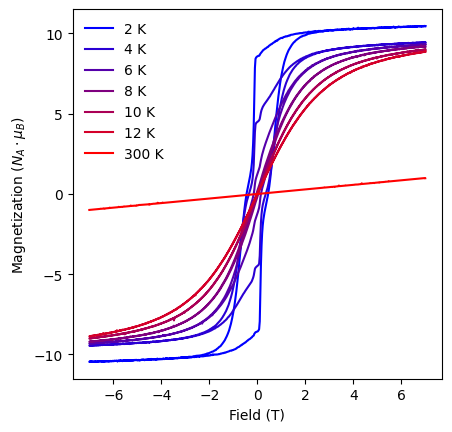

In [25]:
dset1 = mp.Magnetometry(DATA_PATH / "dataset1")
fig, ax = dset1.plot_mvsh()

Now let's make a list of `SimpleMvsHAnalysis` objects for each of the `MvsH` experiments in the dataset.

In [26]:
analyses: list[mp.SimpleMvsHAnalysis] = []
for mvsh in dset1.mvsh:
    temperature = mvsh.temperature
    analysis = mp.SimpleMvsHAnalysis(
        dataset = dset1,
        parsing_args = mp.SimpleMvsHAnalysisParsingArgs(
            temperature = temperature,
            segments = "auto",
        ),
    )
    analyses.append(analysis)

We can inspect the first `SimpleMvsHAnalysis` object to see what information it contains.

In [27]:
analyses[0].as_dict()

{'mvsh': MvsH at 2 K,
 'parsing_args': SimpleMvsHAnalysisParsingArgs(temperature=2, segments='auto'),
 'results': SimpleMvsHAnalysisResults(m_s=10.467101768993821, h_c=4501.3806155, m_r=8.573807168964388, moment_units='bohr magnetons/mol', field_units='Oe', segments=['forward', 'reverse'])}

Note how the `MvsH` object appears when converted to json. Someone reading a file containing the json representation of the `SimpleMvsHAnalysis` object would have access to:

  - the input data: the name of the file from which the data was read, the temperature of the experiment, the scaling applied to the data (in this case a molar scaling with a correction for the eicosane matrix)
  - the parsing arguments: in this case the temperature used to select the proper `MvsH` object from the dataset and the method in which segments of the M vs. H experiment were selected for analysis (in this case `"auto"`, meaning that the analysis will use forward and/or reverse scans depending on availability)
  - the results of the the analysis: this include the actual values along with units and a list of analyzed segments

In [28]:
print(json.dumps(analyses[0].as_dict(), indent=4, default=(lambda x: x.as_dict())))

{
    "mvsh": {
        "origin_file": "mvsh1.dat",
        "temperature": 2,
        "field_range": [
            -70000.35156,
            70000.375
        ],
        "field_correction_file": "",
        "scaling": [
            "molar",
            "eicosane"
        ]
    },
    "parsing_args": {
        "temperature": 2,
        "segments": "auto"
    },
    "results": {
        "m_s": 10.467101768993821,
        "h_c": 4501.3806155,
        "m_r": 8.573807168964388,
        "moment_units": "bohr magnetons/mol",
        "field_units": "Oe",
        "segments": [
            "forward",
            "reverse"
        ]
    }
}


All of the analyses can be added to the `Magnetometry` object using the `add_analysis()` method.

In [29]:
dset1.add_analysis(analyses)

When we're finished working on this dataset, we can serialize the `Magnetometry` object to a json file using the [`create_report()`](../../api/magnetometry/#magnetopy.magnetometry.Magnetometry.create_report) method. [The report can be viewed here](../dataset1.json) (it may help to install a json viewer extension for your browser, like [this one for Chrome](https://chrome.google.com/webstore/detail/json-viewer/gbmdgpbipfallnflgajpaliibnhdgobh)).

In [30]:
dset1.create_report(".")

Aborting report creation.


Alternatively, here is the json representation of the `Magnetometry` object as printed in the notebook:

In [31]:
print(dset1.as_json(indent=4))

{
    "sample_id": "dataset1",
    "files": [
        {
            "experiment_type": "magnetometry",
            "local_path": "../../tests/data/dataset1/mvsh1.dat",
            "length": 2604806,
            "date_created": "2020-07-11T11:07:00",
            "sha512": "f9f8ac5d5b84cc00a57073d330c0f8b005e90201eadc588649388a35666f427bdc6beaa9c8ef5d58e70099a54ced7d9006f9800b8014639e790a2f0423acd6a5",
            "experiments_in_file": [
                "mvsh"
            ]
        },
        {
            "experiment_type": "magnetometry",
            "local_path": "../../tests/data/dataset1/zfcfc1.dat",
            "length": 261387,
            "date_created": "2021-09-18T19:46:00",
            "sha512": "4936c3d7b1733a51c318754134a7a04ec6e0a7edc75e20cec8488df8ae14409d72370f0a77855dc9ebf704734e81cf21f0beb7c10b38a37514742cea0168979d",
            "experiments_in_file": [
                "zfcfc"
            ]
        }
    ],
    "sample_info": {
        "material": "[Er(TiPS2COT)I(THF)